## **Load libraries and necessary data**

In [45]:
%%capture
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

In [44]:
%%capture
# Update OpenAI to 1.3
from importlib.metadata import version
try:
    assert version('openai') == '1.3.0'
except:
    !pip install openai==1.3.0
from openai import OpenAI

In [56]:
from getpass import getpass
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial import distance
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [43]:
token = getpass('Enter token here')

Enter token here··········


In [46]:
reviews = pd.read_csv("/content/womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [47]:
reviews.shape

(1000, 11)

## **Create and store the embeddings**
Embed the reviews using a suitable text embedding algorithm and store them as list in the variable embeddings.

In [48]:
client = OpenAI(api_key=token)

In [49]:
reviews[reviews['Review Text'].isna() == True].shape[0]

42

In [51]:
review_texts = reviews["Review Text"].dropna()

In [53]:
reviews_embeddings = client.embeddings.create(input=review_texts.tolist(), model='text-embedding-ada-002').model_dump()

## **Dimensionality reduction & visualization**
Apply an appropriate dimensionality reduction technique to reduce the embeddings to a 2-dimensional numpy array. Then, plot a 2D visual representation of the reviews.

In [55]:
embeddings = [review["embedding"] for review in reviews_embeddings['data']]

In [57]:
def dem_reduction(embeddings):
  tsne = TSNE(n_components=2, random_state=0)
  return tsne.fit_transform(embeddings)

In [59]:
len(embeddings[0])

1536

In [60]:
embeddings_2d = dem_reduction(np.array(embeddings))

In [62]:
embeddings_2d[0]

array([  7.5603776, -24.305788 ], dtype=float32)

In [63]:
len(embeddings_2d)

958

In [64]:
def visualise_2d(reduced_embeddings):
  plt.figure(figsize=(12, 8))
  for i, point in enumerate(reduced_embeddings):
    plt.scatter(point[0], point[1], alpha=0.5)
    plt.text(point[0], point[1], str(i), verticalalignment='center')
  plt.title("t-SNE Visualization of Review Embeddings")
  plt.xlabel("t-SNE feature 1")
  plt.ylabel("t-SNE feature 2")
  plt.show()

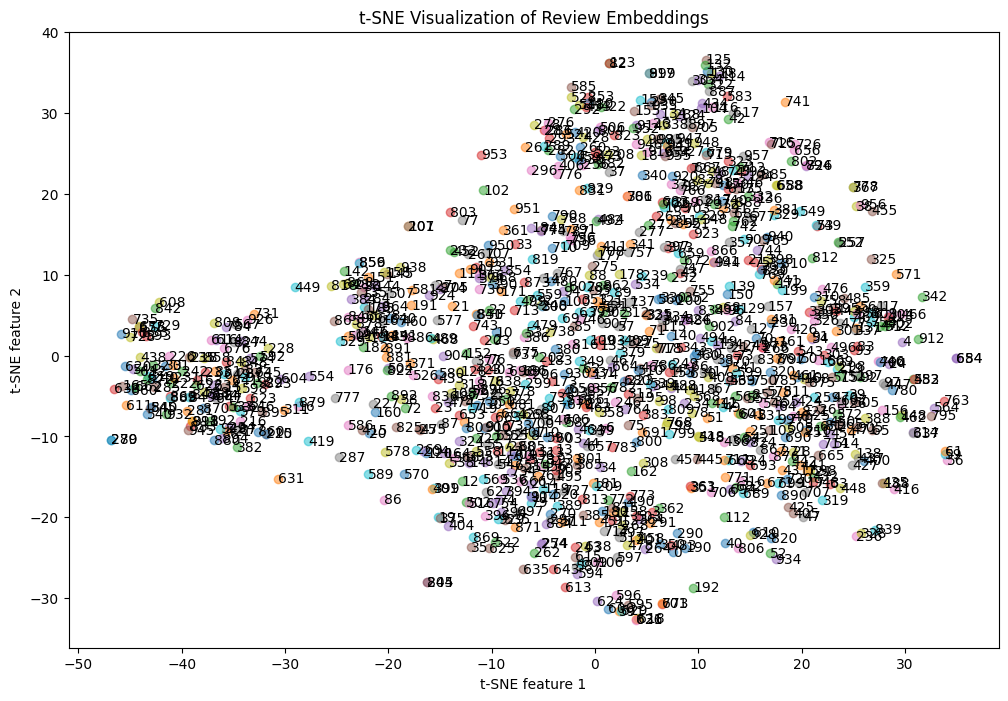

In [66]:
visualise_2d(embeddings_2d)

## **Feedback categorization**
Use your embeddings to identify some reviews that discuss topics such as 'quality', 'fit', 'style', 'comfort', etc.

In [115]:
categories = ['Quality', 'Fit', 'Style', 'Comfort']

category_embedded = client.embeddings.create(input=categories, model='text-embedding-ada-002').model_dump()
category_embeddings = [category['embedding'] for category in category_embedded['data']]

In [119]:
def identify_topic(text_embedding, embeddings_for_categories):
  sim_dist = [{'distance': distance.cosine(text_embedding, category), "index": i} for i, category in enumerate(embeddings_for_categories)]
  closest = min(sim_dist, key=lambda x: x['distance'])
  return categories[closest['index']]

In [120]:
identified_topic = [identify_topic(text, category_embeddings) for text in embeddings]

In [121]:
set(identified_topic)

{'Comfort', 'Fit', 'Quality', 'Style'}

In [122]:
from collections import Counter
Counter(identified_topic)

Counter({'Comfort': 36, 'Fit': 900, 'Quality': 21, 'Style': 1})

## **Similarity search function**
Write a function that outputs the closest 3 reviews to a given input review, enabling a more personalized customer service response.
Apply this function to the first review "Absolutely wonderful - silky and sexy and comfortable", and store the output as a list.

In [82]:
client_db = chromadb.PersistentClient()

review_embeddings_db = client_db.create_collection(
    name='review_embeddings',
    embedding_function=OpenAIEmbeddingFunction(api_key=getpass('Enter token here'))
)

Enter token here··········


In [84]:
review_embeddings_db.add(
    documents=review_texts.tolist(),
    ids = [str(i) for i in range(len(review_texts))]
)

In [91]:
def find_similar_reviews(text, vector_df, n=3):
  collection = client_db.get_collection(
      name='review_embeddings',
      embedding_function=OpenAIEmbeddingFunction(api_key=getpass('Enter token here')
  ))
  results = collection.query(
      query_texts = [text],
      n_results=n
  )

  return results

In [92]:
example = "Absolutely wonderful - silky and sexy and comfortable"
three_similar_reviews = find_similar_reviews(example, review_embeddings_db, 3)

Enter token here··········


In [93]:
three_similar_reviews

{'ids': [['0', '483', '81']],
 'distances': [[4.831483693124028e-06,
   0.22304248809814453,
   0.24486058950424194]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['Absolutely wonderful - silky and sexy and comfortable',
   'Very comfortable and versatile. got lots of compliments.',
   'Loved this top. great design. comfortable and unique. soft material']],
 'uris': None,
 'data': None}

In [97]:
for i, rev in enumerate(three_similar_reviews['documents'][0]):
  print(f"{i+1}. {rev}")

1. Absolutely wonderful - silky and sexy and comfortable
2. Very comfortable and versatile. got lots of compliments.
3. Loved this top. great design. comfortable and unique. soft material


In [124]:
client_db.delete_collection(name="review_embeddings")